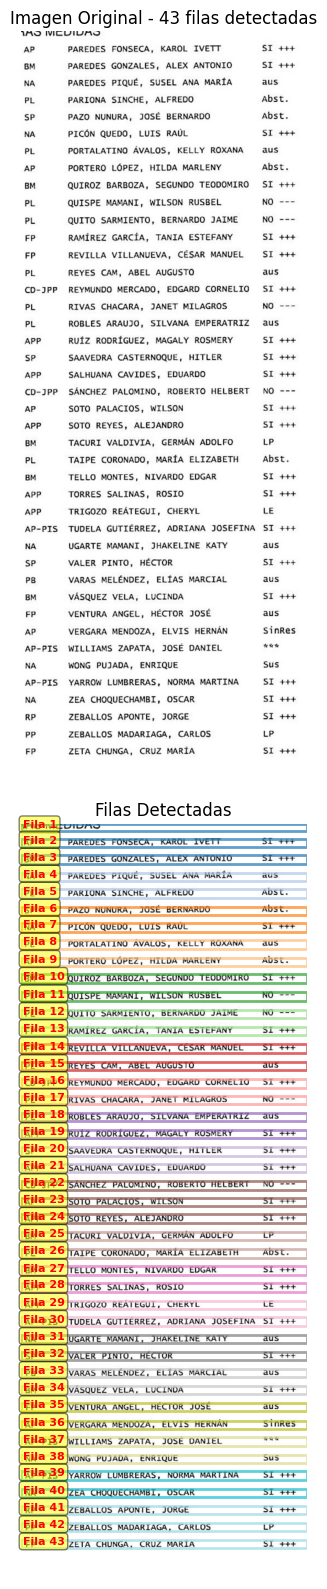


✅ Total de filas detectadas: 43

Coordenadas de cada fila:
--------------------------------------------------
Fila  1: Y=  0 a Y= 18 (altura=18px)
Fila  2: Y= 40 a Y= 62 (altura=22px)
Fila  3: Y= 86 a Y=109 (altura=23px)
Fila  4: Y=133 a Y=155 (altura=22px)
Fila  5: Y=179 a Y=202 (altura=23px)
Fila  6: Y=226 a Y=248 (altura=22px)
Fila  7: Y=271 a Y=295 (altura=24px)
Fila  8: Y=318 a Y=341 (altura=23px)
Fila  9: Y=366 a Y=388 (altura=22px)
Fila 10: Y=411 a Y=436 (altura=25px)
Fila 11: Y=460 a Y=484 (altura=24px)
Fila 12: Y=508 a Y=532 (altura=24px)
Fila 13: Y=555 a Y=578 (altura=23px)
Fila 14: Y=603 a Y=626 (altura=23px)
Fila 15: Y=651 a Y=674 (altura=23px)
Fila 16: Y=697 a Y=721 (altura=24px)
Fila 17: Y=744 a Y=767 (altura=23px)
Fila 18: Y=790 a Y=813 (altura=23px)
Fila 19: Y=837 a Y=860 (altura=23px)
Fila 20: Y=883 a Y=907 (altura=24px)
Fila 21: Y=930 a Y=952 (altura=22px)
Fila 22: Y=976 a Y=1000 (altura=24px)
Fila 23: Y=1023 a Y=1045 (altura=22px)
Fila 24: Y=1068 a Y=1092 (altura=24

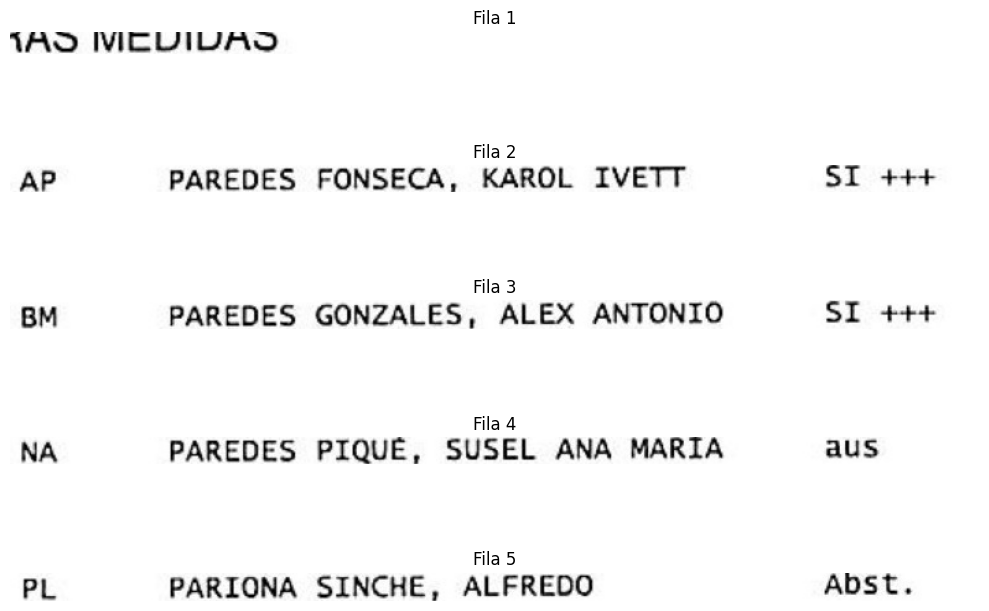


📝 Primeras 3 anotaciones en formato YOLO:
0 0.500000 0.004356 1.000000 0.008712
0 0.500000 0.024685 1.000000 0.010649
0 0.500000 0.047193 1.000000 0.011133


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Cargar la imagen
img_path = './image_0.png'
imagen = cv2.imread(img_path)
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

def detectar_filas_mejorado(imagen):
    """
    Detecta filas en una imagen de tabla usando procesamiento clásico
    """
    # Convertir a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Aplicar threshold para obtener imagen binaria
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    
    # Crear kernel horizontal largo para detectar líneas de texto
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (imagen.shape[1]//2, 1))
    
    # Detectar líneas horizontales
    horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    # Dilatar para conectar componentes cercanos
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (imagen.shape[1]//4, 3))
    horizontal_lines = cv2.dilate(horizontal_lines, kernel_dilate, iterations=1)
    
    # Proyección horizontal para encontrar filas
    horizontal_projection = np.sum(binary, axis=1)
    
    # Encontrar picos en la proyección (inicio/fin de filas)
    threshold_projection = np.mean(horizontal_projection) * 0.3
    row_positions = []
    in_row = False
    start_y = 0
    
    for y in range(len(horizontal_projection)):
        if horizontal_projection[y] > threshold_projection:
            if not in_row:
                start_y = y
                in_row = True
        else:
            if in_row:
                if y - start_y > 10:  # Altura mínima de fila
                    row_positions.append((start_y, y))
                in_row = False
    
    # Si la última fila no se cerró
    if in_row and len(horizontal_projection) - start_y > 10:
        row_positions.append((start_y, len(horizontal_projection)))
    
    # Crear bounding boxes para cada fila
    filas = []
    margen = 2  # Margen adicional para capturar toda la fila
    
    for start_y, end_y in row_positions:
        # Expandir ligeramente los límites
        y1 = max(0, start_y - margen)
        y2 = min(imagen.shape[0], end_y + margen)
        altura = y2 - y1
        
        # Solo incluir si tiene altura razonable
        if 15 < altura < 100:  # Ajusta estos valores según tu imagen
            filas.append({
                'x': 0,
                'y': y1,
                'width': imagen.shape[1],
                'height': altura,
                'bbox': (0, y1, imagen.shape[1], altura)
            })
    
    return filas

# Detectar filas
filas_detectadas = detectar_filas_mejorado(imagen)

# Visualizar resultados
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Imagen original
axes[0].imshow(imagen_rgb)
axes[0].set_title(f'Imagen Original - {len(filas_detectadas)} filas detectadas')
axes[0].axis('off')

# Imagen con filas detectadas
axes[1].imshow(imagen_rgb)
axes[1].set_title('Filas Detectadas')
axes[1].axis('off')

# Dibujar rectángulos para cada fila
colores = plt.cm.tab20(np.linspace(0, 1, len(filas_detectadas)))

for idx, fila in enumerate(filas_detectadas):
    rect = Rectangle(
        (fila['x'], fila['y']), 
        fila['width'], 
        fila['height'],
        linewidth=2, 
        edgecolor=colores[idx], 
        facecolor='none',
        alpha=0.7
    )
    axes[1].add_patch(rect)
    
    # Añadir número de fila
    axes[1].text(
        fila['x'] + 5, 
        fila['y'] + fila['height']/2, 
        f"Fila {idx+1}", 
        color='red', 
        fontsize=8, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5)
    )

plt.tight_layout()
plt.show()

# Imprimir información de las filas detectadas
print(f"\n✅ Total de filas detectadas: {len(filas_detectadas)}\n")
print("Coordenadas de cada fila:")
print("-" * 50)
for idx, fila in enumerate(filas_detectadas):
    print(f"Fila {idx+1:2d}: Y={fila['y']:3d} a Y={fila['y']+fila['height']:3d} (altura={fila['height']:2d}px)")

# Opcional: Extraer y mostrar cada fila individualmente
def mostrar_filas_individuales(imagen, filas, max_filas=5):
    """Muestra las primeras max_filas como imágenes separadas"""
    num_filas = min(len(filas), max_filas)
    
    if num_filas == 0:
        print("No hay filas para mostrar")
        return
    
    fig, axes = plt.subplots(num_filas, 1, figsize=(10, num_filas * 1.5))
    
    if num_filas == 1:
        axes = [axes]
    
    for idx in range(num_filas):
        fila = filas[idx]
        y1 = fila['y']
        y2 = fila['y'] + fila['height']
        
        # Extraer la región de la fila
        fila_img = imagen_rgb[y1:y2, :]
        
        axes[idx].imshow(fila_img)
        axes[idx].set_title(f'Fila {idx+1}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar las primeras 5 filas individualmente
print("\n📋 Primeras 5 filas extraídas:")
mostrar_filas_individuales(imagen, filas_detectadas, max_filas=5)

# Guardar las coordenadas para uso posterior (por ejemplo, para entrenar YOLO)
def exportar_coordenadas_yolo(filas, img_height, img_width, output_path=None):
    """
    Exporta las coordenadas en formato YOLO
    """
    yolo_annotations = []
    
    for fila in filas:
        # Convertir a formato YOLO (normalizado 0-1)
        x_center = (fila['x'] + fila['width']/2) / img_width
        y_center = (fila['y'] + fila['height']/2) / img_height
        width = fila['width'] / img_width
        height = fila['height'] / img_height
        
        # Clase 0 (solo tenemos una clase: "fila")
        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    if output_path:
        with open(output_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
        print(f"\n✅ Anotaciones YOLO guardadas en: {output_path}")
    
    return yolo_annotations

# Generar anotaciones en formato YOLO
anotaciones_yolo = exportar_coordenadas_yolo(
    filas_detectadas, 
    imagen.shape[0], 
    imagen.shape[1]
)

print("\n📝 Primeras 3 anotaciones en formato YOLO:")
for ann in anotaciones_yolo[:3]:
    print(ann)

🚀 Iniciando procesamiento de múltiples imágenes...

📄 Procesando: ./image_0.png
   ✅ Filas detectadas: 43
   📊 Tipo de columna: completa

📄 Procesando: ./image_1.png
   ✅ Filas detectadas: 44
   📊 Tipo de columna: partido

📄 Procesando: ./image_2.png
   ✅ Filas detectadas: 44
   📊 Tipo de columna: nombres

📄 Procesando: ./image_3.png
   ✅ Filas detectadas: 44
   📊 Tipo de columna: votos


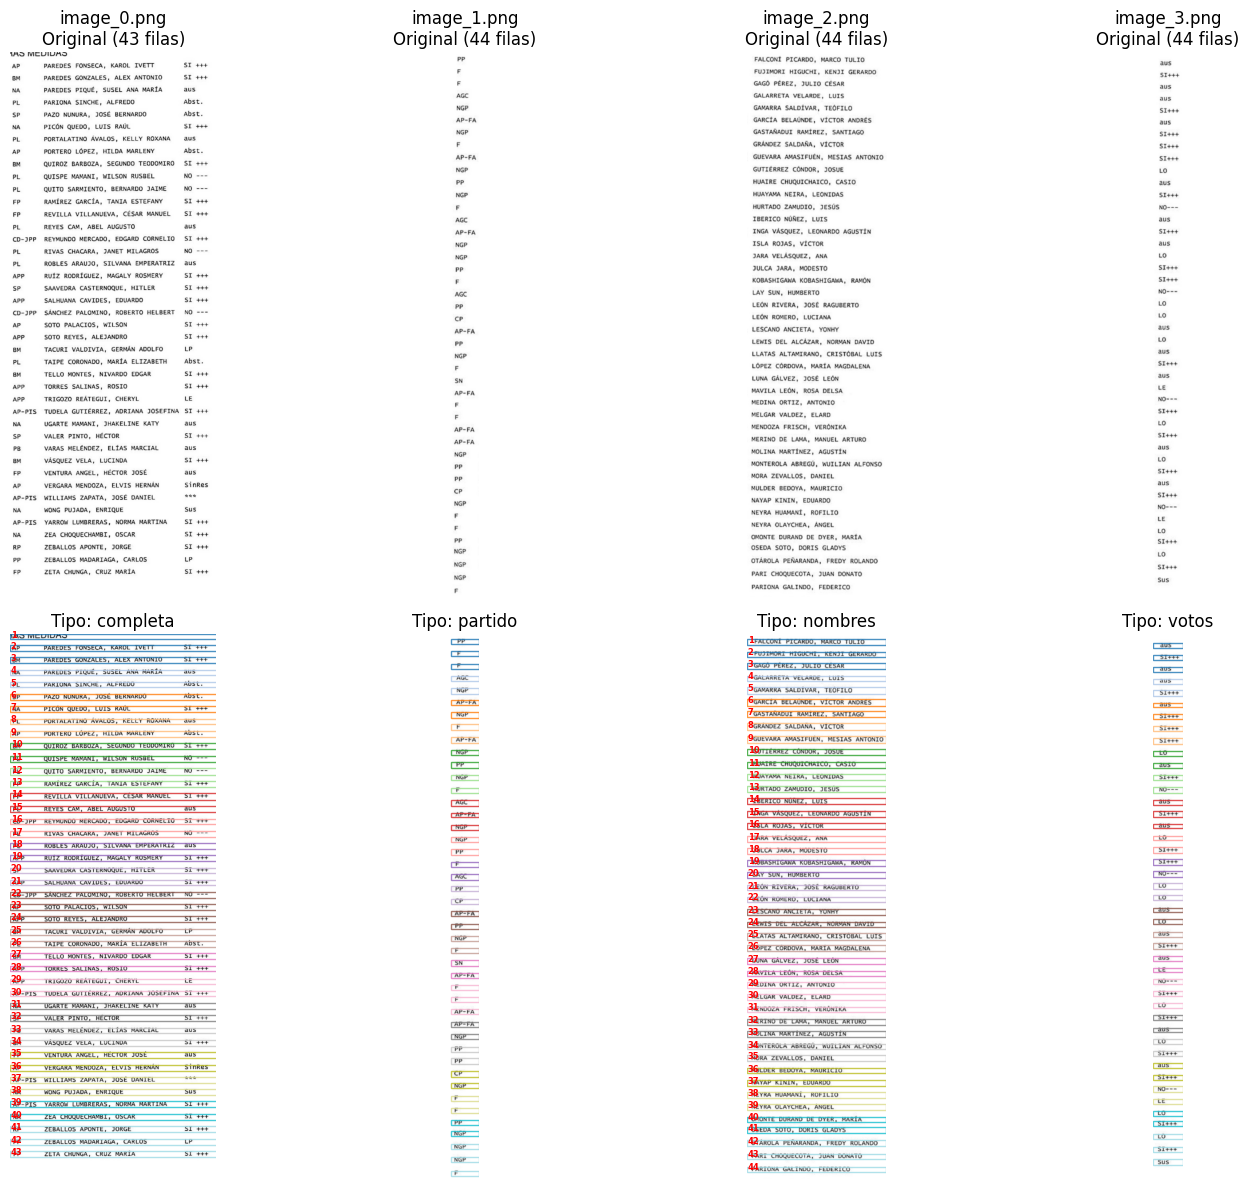


🔄 Alineación de filas entre columnas:

image_0.png (completa):
  Filas detectadas: 43
  Rango Y: 0 - 1960

image_1.png (partido):
  Filas detectadas: 44
  Rango Y: 10 - 1181

image_2.png (nombres):
  Filas detectadas: 44
  Rango Y: 10 - 1181

image_3.png (votos):
  Filas detectadas: 44
  Rango Y: 20 - 1188

💾 Exportando anotaciones YOLO a ./yolo_annotations/
  ✅ image_0.txt: 43 anotaciones
  ✅ image_1.txt: 44 anotaciones
  ✅ image_2.txt: 44 anotaciones
  ✅ image_3.txt: 44 anotaciones

📊 RESUMEN FINAL:
Total de filas detectadas en todas las imágenes: 175
  - image_0.png: 43 filas
  - image_1.png: 44 filas
  - image_2.png: 44 filas
  - image_3.png: 44 filas


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

def detectar_filas_adaptado(imagen, tipo_columna='completa'):
    """
    Detecta filas adaptándose al tipo de columna
    tipo_columna: 'completa', 'partido', 'nombres', 'votos'
    """
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    
    # Proyección horizontal
    horizontal_projection = np.sum(binary, axis=1)
    
    # Ajustar threshold según el tipo de columna
    if tipo_columna == 'partido':
        threshold_factor = 0.1  # Más sensible para columnas estrechas
        min_altura = 5
    elif tipo_columna == 'votos':
        threshold_factor = 0.1
        min_altura = 5
    else:
        threshold_factor = 0.1
        min_altura = 5
    
    threshold_projection = np.mean(horizontal_projection) * threshold_factor
    
    # Encontrar filas
    row_positions = []
    in_row = False
    start_y = 0
    
    for y in range(len(horizontal_projection)):
        if horizontal_projection[y] > threshold_projection:
            if not in_row:
                start_y = y
                in_row = True
        else:
            if in_row:
                if y - start_y > min_altura:
                    row_positions.append((start_y, y))
                in_row = False
    
    # Cerrar última fila si es necesario
    if in_row and len(horizontal_projection) - start_y > min_altura:
        row_positions.append((start_y, len(horizontal_projection)))
    
    # Crear bounding boxes
    filas = []
    margen = 1
    
    for start_y, end_y in row_positions:
        y1 = max(0, start_y - margen)
        y2 = min(imagen.shape[0], end_y + margen)
        altura = y2 - y1
        
        # Ajustar altura según tipo
        max_altura = 150 if tipo_columna == 'partido' else 100
        
        if min_altura < altura < max_altura:
            filas.append({
                'x': 0,
                'y': y1,
                'width': imagen.shape[1],
                'height': altura,
                'bbox': (0, y1, imagen.shape[1], altura)
            })
    
    return filas

def procesar_multiples_imagenes(imagenes_paths):
    """
    Procesa múltiples imágenes y detecta filas en cada una
    """
    resultados = {}
    
    # Configurar tipos para cada imagen
    tipos_columna = {
        'image_0.png': 'completa',  # Tabla completa
        'image_1.png': 'partido',   # Solo partidos (columna estrecha)
        'image_2.png': 'nombres',   # Solo nombres
        'image_3.png': 'votos'      # Solo votos
    }
    
    for img_path in imagenes_paths:
        if os.path.exists(img_path):
            print(f"\n📄 Procesando: {img_path}")
            
            # Cargar imagen
            imagen = cv2.imread(img_path)
            imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
            
            # Determinar tipo de columna
            filename = os.path.basename(img_path)
            tipo = tipos_columna.get(filename, 'completa')
            
            # Detectar filas
            filas = detectar_filas_adaptado(imagen, tipo_columna=tipo)
            
            resultados[img_path] = {
                'imagen': imagen_rgb,
                'filas': filas,
                'tipo': tipo
            }
            
            print(f"   ✅ Filas detectadas: {len(filas)}")
            print(f"   📊 Tipo de columna: {tipo}")
    
    return resultados

def visualizar_todas_las_imagenes(resultados):
    """
    Visualiza todas las imágenes con sus filas detectadas
    """
    num_imagenes = len(resultados)
    
    if num_imagenes == 0:
        print("No hay resultados para visualizar")
        return
    
    # Crear subplots
    fig, axes = plt.subplots(2, num_imagenes, figsize=(4*num_imagenes, 12))
    
    if num_imagenes == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (path, data) in enumerate(resultados.items()):
        imagen = data['imagen']
        filas = data['filas']
        tipo = data['tipo']
        filename = os.path.basename(path)
        
        # Imagen original
        axes[0, idx].imshow(imagen)
        axes[0, idx].set_title(f'{filename}\nOriginal ({len(filas)} filas)')
        axes[0, idx].axis('off')
        
        # Imagen con filas detectadas
        axes[1, idx].imshow(imagen)
        axes[1, idx].set_title(f'Tipo: {tipo}')
        axes[1, idx].axis('off')
        
        # Dibujar rectángulos
        colores = plt.cm.tab20(np.linspace(0, 1, max(len(filas), 1)))
        
        for fila_idx, fila in enumerate(filas):
            rect = Rectangle(
                (fila['x'], fila['y']), 
                fila['width'], 
                fila['height'],
                linewidth=1, 
                edgecolor=colores[fila_idx % len(colores)], 
                facecolor='none',
                alpha=0.8
            )
            axes[1, idx].add_patch(rect)
            
            # Número de fila (solo si hay espacio)
            if imagen.shape[1] > 100:  # Solo en columnas anchas
                axes[1, idx].text(
                    fila['x'] + 2, 
                    fila['y'] + fila['height']/2, 
                    f"{fila_idx+1}", 
                    color='red', 
                    fontsize=6, 
                    fontweight='bold'
                )
    
    plt.tight_layout()
    plt.show()

def alinear_filas_entre_imagenes(resultados):
    """
    Alinea las filas detectadas entre diferentes columnas
    """
    print("\n🔄 Alineación de filas entre columnas:")
    print("="*60)
    
    # Obtener todas las posiciones Y de todas las imágenes
    todas_las_filas = []
    for path, data in resultados.items():
        for fila in data['filas']:
            todas_las_filas.append(fila['y'])
    
    if not todas_las_filas:
        print("No se detectaron filas")
        return
    
    # Ordenar y encontrar el número máximo de filas
    todas_las_filas.sort()
    
    # Mostrar resumen
    for path, data in resultados.items():
        filename = os.path.basename(path)
        print(f"\n{filename} ({data['tipo']}):")
        print(f"  Filas detectadas: {len(data['filas'])}")
        
        if len(data['filas']) > 0:
            primera = data['filas'][0]['y']
            ultima = data['filas'][-1]['y']
            print(f"  Rango Y: {primera} - {ultima}")

# EJECUTAR TODO
# Lista de imágenes a procesar
imagenes_paths = [
    './image_0.png',  # Tabla completa
    './image_1.png',  # Solo partidos
    './image_2.png',  # Solo nombres
    './image_3.png'   # Solo votos
]

# Procesar todas las imágenes
print("🚀 Iniciando procesamiento de múltiples imágenes...")
resultados = procesar_multiples_imagenes(imagenes_paths)

# Visualizar resultados
visualizar_todas_las_imagenes(resultados)

# Alinear filas
alinear_filas_entre_imagenes(resultados)

# Exportar coordenadas consolidadas
def exportar_todas_las_coordenadas(resultados, output_dir='./yolo_annotations/'):
    """
    Exporta todas las anotaciones YOLO para cada imagen
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n💾 Exportando anotaciones YOLO a {output_dir}")
    
    for path, data in resultados.items():
        filename = os.path.basename(path).replace('.png', '.txt')
        output_path = os.path.join(output_dir, filename)
        
        # Obtener dimensiones de la imagen original
        imagen_shape = data['imagen'].shape
        
        with open(output_path, 'w') as f:
            for fila in data['filas']:
                x_center = 0.5  # Siempre centrado horizontalmente
                y_center = (fila['y'] + fila['height']/2) / imagen_shape[0]
                width = 1.0  # Ancho completo
                height = fila['height'] / imagen_shape[0]
                
                f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
        
        print(f"  ✅ {filename}: {len(data['filas'])} anotaciones")

# Exportar si lo necesitas
exportar_todas_las_coordenadas(resultados)

# Mostrar estadísticas finales
print("\n📊 RESUMEN FINAL:")
print("="*60)
total_filas = sum(len(data['filas']) for data in resultados.values())
print(f"Total de filas detectadas en todas las imágenes: {total_filas}")
for path, data in resultados.items():
    print(f"  - {os.path.basename(path)}: {len(data['filas'])} filas")

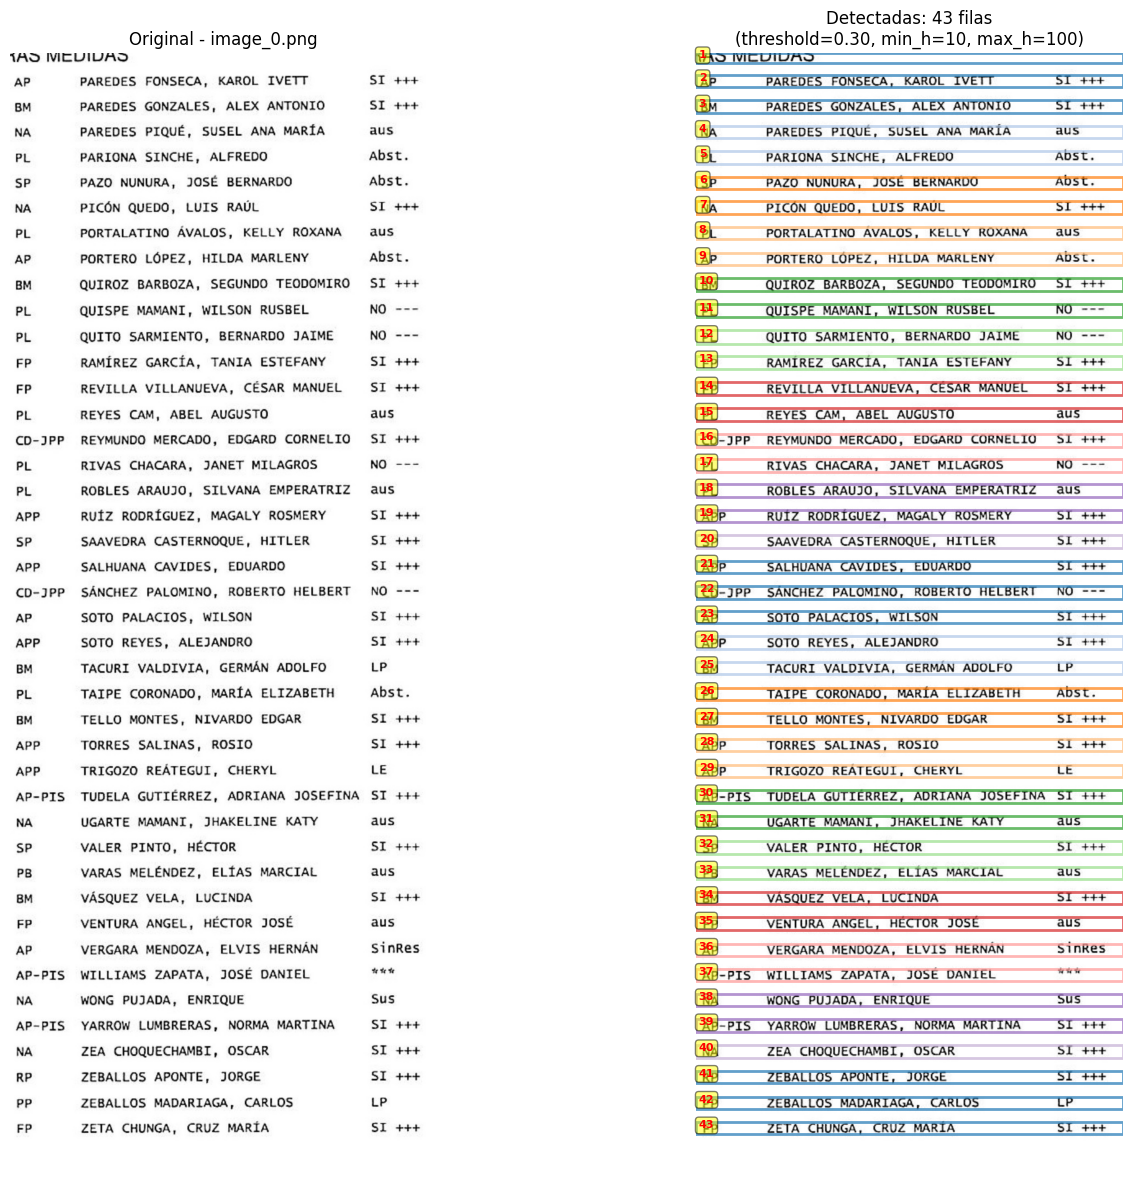


📊 RESUMEN - image_0.png
Filas detectadas: 43
Parámetros usados:
  - threshold_factor: 0.3
  - min_altura: 10px
  - max_altura: 100px
  - margen: 2px
Estadísticas de altura:
  - Mínima: 18px
  - Máxima: 25px
  - Promedio: 22.8px
✅ Anotaciones guardadas en: annotations/image_1.txt


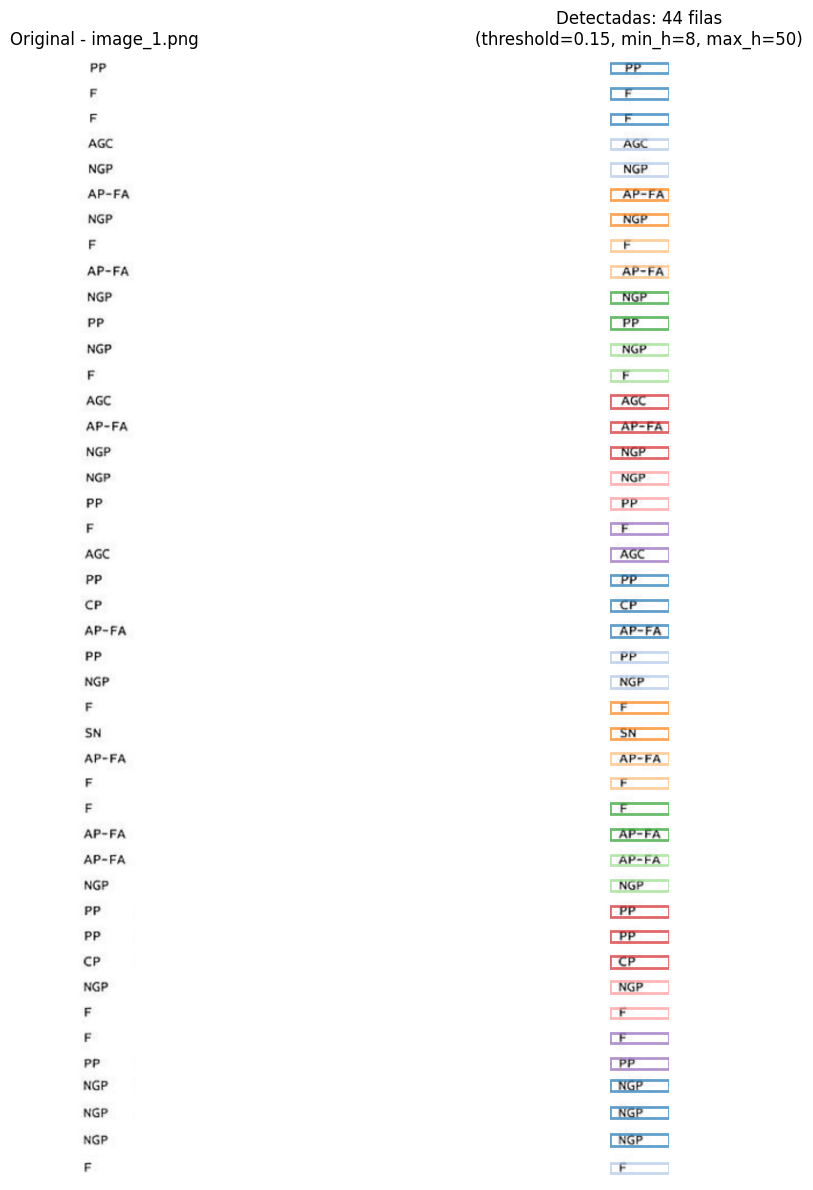


📊 RESUMEN - image_1.png
Filas detectadas: 44
Parámetros usados:
  - threshold_factor: 0.15
  - min_altura: 8px
  - max_altura: 50px
  - margen: 1px
Estadísticas de altura:
  - Mínima: 11px
  - Máxima: 13px
  - Promedio: 11.8px


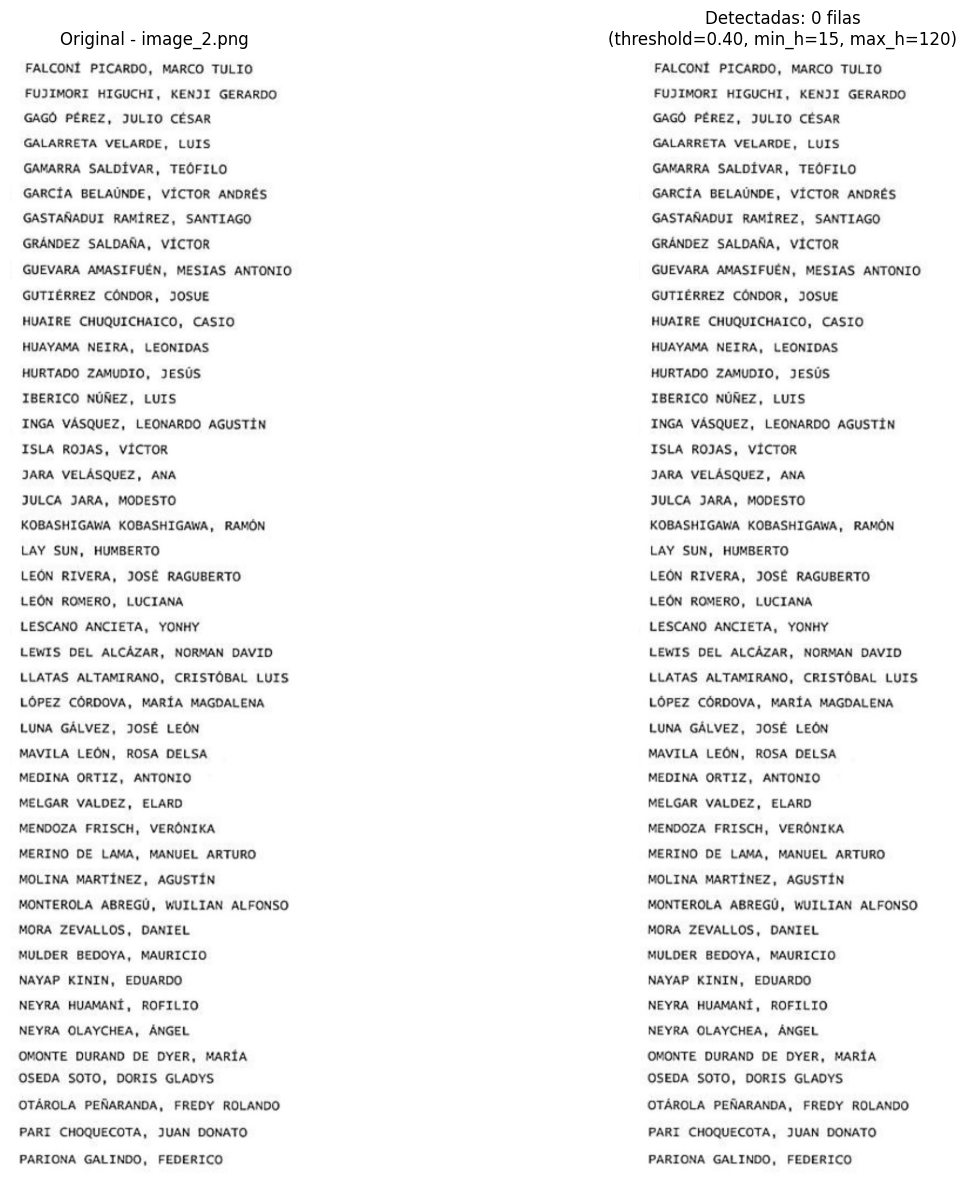


📊 RESUMEN - image_2.png
Filas detectadas: 0
Parámetros usados:
  - threshold_factor: 0.4
  - min_altura: 15px
  - max_altura: 120px
  - margen: 2px


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

def detectar_y_anotar_filas(image_path, 
                           annotation_path=None,
                           threshold_factor=0.3,
                           min_altura=10,
                           max_altura=100,
                           margen=2,
                           visualizar=True,
                           mostrar_filas_individuales=False,
                           max_filas_mostrar=5):
    """
    Función completa para detectar filas y generar anotaciones YOLO
    
    Parámetros:
    -----------
    image_path : str
        Ruta de la imagen a procesar
    annotation_path : str, optional
        Ruta donde guardar las anotaciones YOLO (si es None, no guarda)
    threshold_factor : float
        Factor para el threshold de detección (0.1-1.0, menor = más sensible)
    min_altura : int
        Altura mínima en píxeles para considerar una fila
    max_altura : int
        Altura máxima en píxeles para considerar una fila
    margen : int
        Píxeles adicionales arriba/abajo de cada fila
    visualizar : bool
        Si mostrar la visualización con matplotlib
    mostrar_filas_individuales : bool
        Si mostrar cada fila detectada por separado
    max_filas_mostrar : int
        Número máximo de filas individuales a mostrar
    
    Retorna:
    --------
    dict : Diccionario con:
        - 'filas': lista de diccionarios con las filas detectadas
        - 'total': número total de filas detectadas
        - 'anotaciones_yolo': lista de strings en formato YOLO
        - 'imagen_shape': tuple con (height, width, channels)
    """
    
    # Verificar que la imagen existe
    if not os.path.exists(image_path):
        print(f"❌ Error: No se encuentra la imagen {image_path}")
        return None
    
    # Cargar imagen
    imagen = cv2.imread(image_path)
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Binarización
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    
    # Proyección horizontal
    horizontal_projection = np.sum(binary, axis=1)
    
    # Calcular threshold
    threshold_projection = np.mean(horizontal_projection) * threshold_factor
    
    # Detectar inicio y fin de filas
    row_positions = []
    in_row = False
    start_y = 0
    
    for y in range(len(horizontal_projection)):
        if horizontal_projection[y] > threshold_projection:
            if not in_row:
                start_y = y
                in_row = True
        else:
            if in_row:
                if y - start_y > min_altura:
                    row_positions.append((start_y, y))
                in_row = False
    
    # Cerrar última fila si quedó abierta
    if in_row and len(horizontal_projection) - start_y > min_altura:
        row_positions.append((start_y, len(horizontal_projection)))
    
    # Crear bounding boxes
    filas = []
    for start_y, end_y in row_positions:
        y1 = max(0, start_y - margen)
        y2 = min(imagen.shape[0], end_y + margen)
        altura = y2 - y1
        
        if min_altura < altura < max_altura:
            filas.append({
                'x': 0,
                'y': y1,
                'width': imagen.shape[1],
                'height': altura,
                'bbox': (0, y1, imagen.shape[1], altura)
            })
    
    # Generar anotaciones YOLO
    anotaciones_yolo = []
    for fila in filas:
        x_center = (fila['x'] + fila['width']/2) / imagen.shape[1]
        y_center = (fila['y'] + fila['height']/2) / imagen.shape[0]
        width = fila['width'] / imagen.shape[1]
        height = fila['height'] / imagen.shape[0]
        anotaciones_yolo.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    # Guardar anotaciones si se especificó path
    if annotation_path:
        os.makedirs(os.path.dirname(annotation_path) if os.path.dirname(annotation_path) else '.', exist_ok=True)
        with open(annotation_path, 'w') as f:
            f.write('\n'.join(anotaciones_yolo))
        print(f"✅ Anotaciones guardadas en: {annotation_path}")
    
    # Visualización
    if visualizar:
        # Calcular el tamaño de figura basado en el tamaño de la imagen
        fig_width = min(15, max(8, imagen.shape[1] / 100))
        fig_height = min(12, max(6, imagen.shape[0] / 100))
        
        fig, axes = plt.subplots(1, 2, figsize=(fig_width*2, fig_height))
        
        # Imagen original
        axes[0].imshow(imagen_rgb)
        axes[0].set_title(f'Original - {os.path.basename(image_path)}')
        axes[0].axis('off')
        
        # Imagen con detecciones
        axes[1].imshow(imagen_rgb)
        axes[1].set_title(f'Detectadas: {len(filas)} filas\n' + 
                         f'(threshold={threshold_factor:.2f}, min_h={min_altura}, max_h={max_altura})')
        axes[1].axis('off')
        
        # Dibujar rectángulos
        colores = plt.cm.tab20(np.linspace(0, 1, max(len(filas), 1)))
        
        for idx, fila in enumerate(filas):
            rect = Rectangle(
                (fila['x'], fila['y']), 
                fila['width'], 
                fila['height'],
                linewidth=2, 
                edgecolor=colores[idx % 20], 
                facecolor='none',
                alpha=0.7
            )
            axes[1].add_patch(rect)
            
            # Añadir número si la imagen es suficientemente ancha
            if imagen.shape[1] > 150:
                axes[1].text(
                    fila['x'] + 5, 
                    fila['y'] + fila['height']/2, 
                    f"{idx+1}", 
                    color='red', 
                    fontsize=8, 
                    fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5)
                )
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar filas individuales si se solicita
        if mostrar_filas_individuales and len(filas) > 0:
            num_filas_mostrar = min(len(filas), max_filas_mostrar)
            fig, axes = plt.subplots(num_filas_mostrar, 1, 
                                   figsize=(fig_width, num_filas_mostrar * 1.5))
            
            if num_filas_mostrar == 1:
                axes = [axes]
            
            for idx in range(num_filas_mostrar):
                fila = filas[idx]
                y1 = fila['y']
                y2 = fila['y'] + fila['height']
                fila_img = imagen_rgb[y1:y2, :]
                
                axes[idx].imshow(fila_img)
                axes[idx].set_title(f'Fila {idx+1} (Y: {y1}-{y2}, altura: {fila["height"]}px)')
                axes[idx].axis('off')
            
            plt.suptitle('Filas Individuales Extraídas')
            plt.tight_layout()
            plt.show()
    
    # Imprimir resumen
    print(f"\n📊 RESUMEN - {os.path.basename(image_path)}")
    print("="*50)
    print(f"Filas detectadas: {len(filas)}")
    print(f"Parámetros usados:")
    print(f"  - threshold_factor: {threshold_factor}")
    print(f"  - min_altura: {min_altura}px")
    print(f"  - max_altura: {max_altura}px")
    print(f"  - margen: {margen}px")
    
    if len(filas) > 0:
        alturas = [f['height'] for f in filas]
        print(f"Estadísticas de altura:")
        print(f"  - Mínima: {min(alturas)}px")
        print(f"  - Máxima: {max(alturas)}px")
        print(f"  - Promedio: {np.mean(alturas):.1f}px")
    
    # Retornar resultados
    return {
        'filas': filas,
        'total': len(filas),
        'anotaciones_yolo': anotaciones_yolo,
        'imagen_shape': imagen.shape,
        'parametros': {
            'threshold_factor': threshold_factor,
            'min_altura': min_altura,
            'max_altura': max_altura,
            'margen': margen
        }
    }


# ============= EJEMPLOS DE USO =============

# Ejemplo 1: Uso básico con valores por defecto
resultado = detectar_y_anotar_filas('image_0.png')

# Ejemplo 2: Ajustar parámetros para imagen con filas pequeñas
resultado = detectar_y_anotar_filas(
    image_path='image_1.png',
    annotation_path='annotations/image_1.txt',
    threshold_factor=0.15,  # Más sensible
    min_altura=8,
    max_altura=50,
    margen=1
)

# Ejemplo 3: Para imagen con texto grande
resultado = detectar_y_anotar_filas(
    image_path='image_2.png',
    threshold_factor=0.4,  # Menos sensible
    min_altura=15,
    max_altura=120,
    visualizar=True,
    mostrar_filas_individuales=True,
    max_filas_mostrar=3
)

# Ejemplo 5: Función auxiliar para probar múltiples configuraciones
def probar_configuraciones(image_path, configuraciones):
    """
    Prueba múltiples configuraciones y compara resultados
    """
    print(f"\n🔬 Probando configuraciones para: {image_path}")
    print("="*60)
    
    resultados = []
    for i, config in enumerate(configuraciones):
        print(f"\nConfiguración {i+1}: {config}")
        resultado = detectar_y_anotar_filas(
            image_path=image_path,
            **config,
            visualizar=False  # No visualizar para pruebas masivas
        )
        resultados.append({
            'config': config,
            'total_filas': resultado['total'] if resultado else 0
        })
    
    # Mostrar comparación
    print("\n📊 Comparación de resultados:")
    print("-"*60)
    for i, r in enumerate(resultados):
        print(f"Config {i+1}: {r['total_filas']} filas detectadas")
    
    return resultados

# Probar diferentes configuraciones
configuraciones = [
    {'threshold_factor': 0.2, 'min_altura': 10},
    {'threshold_factor': 0.3, 'min_altura': 10},
    {'threshold_factor': 0.3, 'min_altura': 15},
    {'threshold_factor': 0.4, 'min_altura': 10},
]

# resultados_prueba = probar_configuraciones('image_0.png', configuraciones)